# PlayStation Games Info
https://www.kaggle.com/datasets/isaacmenard/playstation-games-info-2152025/data

Features:
* game_name: Title of the game.
* highest_price The highest recorded price (from PlayStation Store, in EUR).
* release_date Release date of the game on the specified PlayStation platform.
* genre Primary and secondary genres (e.g., Action / Adventure).
* publisher Publishing company or studio responsible for release.
* platform PlayStation platform (PS3, PS4, PS5).
* metacritic_score Average critic score (0–100) from Metacritic.
* metacritic_rating_count Number of critic reviews counted on Metacritic.
* metacritic_user_score Average user score (0–10) from Metacritic.
* metacritic_user_rating_count Number of user ratings counted on Metacritic.
* playstation_score PlayStation Store user score (0–5).
* playstation_rating_count Total number of PlayStation Store user ratings.

# Problem description
Can the price of a Playstation game be predicted using release year, genre, publisher, and platform?

In [283]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as sklm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Data Cleaning/Exploratory Data Analysis

In [284]:
# Read in data
df = pd.read_csv("game_details.csv")
print("Original row count: ",df.shape[0])

# Create a unique id to use in later troubleshooting
df['row_id'] = df.index

# Convert highest price to a float
df['highest_price'] = df['highest_price'].str.replace('FREE', '0')
df['highest_price'] = df['highest_price'].str.replace(r'[,€]', '',regex=True).astype(float)

# Convert release date to date
df['release_date'] = pd.to_datetime(df['release_date'])

# Games with a missing date are set to '1970-01-01' - drop
df= df[df.release_date > '1970-01-01']
print("Dropped missing release dates - row count: ",df.shape[0])

# Games with missing prices are set to 10000 - drop
# Games that have been exactly set to 100 or 0 have typically been in error
df= df[df.highest_price < 100]
df= df[df.highest_price > 0]
print("Dropped missing prices - row count: ",df.shape[0])

# Spot checking revealed games that include inaccuracies. Remove from model.
df = df[~df.game_name.isin(['DOOM II (Classic)','Shadow Complex Remastered','Stealth Inc 2: A Game of Clones'
                            ,'The Final Station','	Stikbold! Une aventure de balle au prisonnier'
                            ,'Nova-111','Wolfenstein® II: The New Colossus™ (CUSA07377)'
                            ,'DOOM (1993)','Death Noodle Delivery'
                            ,'Wolfenstein: Youngblood - Trial (International)'
                            ,'Apex Construct Demo','Paper Beast Demo'
                            ,'Dead Island 2'])]

# Create a categorical-ish value from release date for later use
df['release_year'] = df['release_date'].dt.year

# Drop null publishers
df = df[~df['publisher'].isna()]
print("Dropped missing publishers - row count: ",df.shape[0])

# Group together publishers with regional entities
df['publisher'] = df['publisher'].str.title()
publisher_map = {
    'Atari Europe S.A.S.U.':'Atari',
    'Atari Inc.':'Atari',
    'Bandai Namco Entertainment Europe':'Bandai Namco',
    'Bloober Team Na':'Bloober Team',
    'Bloober Team S.A.':'Bloober Team',
    'Capcom U.S.A., Inc.':'Capcom',
    'Ce Europe Limited':'Capcom',
    'Ci Games S.A. T/A United Label':'Ci Games',
    'Ci Games S.A.':'Ci Games',
    'Disney Interactive Studios':'Disney Interactive',
    'Ea Swiss Sarl':'Electronic Arts',
    'Koei Tecmo Europe Ltd':'Koei Tecmo Games',
    'Koei Tecmo Games':'Koei',
    'Larian Studios Games Ltd': 'Larian Studios',
    'Rebellion Interactive Limited':'Rebellion Interactive',
    'Rockstar Games': 'Rockstar',
    'Sega Corporation':'SEGA',
    'Sega Europe Ltd':'SEGA',
    'Sega Of America, Inc.':'SEGA',
    'Sony Interactive Entertainment Europe': 'Sony',
    'Sony Interactive Entertainment':'Sony',
    'Sony Music Entertainment':'Sony',
    'Sony Online Entertainment Llc':'Sony',
    'Square Enix Ltd': 'Square Enix',
    'Thq (Uk) Ltd':'Thq Nordic Gmbh',
    'Tikipod Pty Ltd':'Tikipod Ltd',
    'Ubisoft Entertainment Sa':'Ubisoft',
    'Warner Bros. Interactive':'Warner Bros Interactive Entertainment',
    "Activision Blizzard Int'L Bv":'Activision Blizzard',
}

# Apply mapping
df['publisher_cleaned'] = df['publisher'].replace(publisher_map)

# Model is struggling to predict on indie games - add a flag for indie publishers
# https://www.comintedlabs.io/news/top-50-leading-indie-game-publishers-to-fund-your-indie-games
# https://impress.games/indie-game-publishers-list

indie_publishers = ['Humble Games','Tinybuild Llc','Curve Digital','Devolver Digital'
                    ,'Team 17 Digital Ltd','Gearbox','101Xp Ltd','11 Bit Studios S.A.'
                    ,'2Awesome Studio Sl','3D Realms Entertainment'
                    ,'Abylight','Aksys Games Localization Inc.'
                    ,'Akupara Games','Alawar Entertainment, Inc.'
                    ,'All In! Games S.A.','Annapurna Interactive'
                    ,'Arc Games','Armor Games Inc','Assemble Entertainment Gmbh',
                    'Astragon Entertainment Gmbh','Autumn Games',
                    'Blowfish Studios Pty Ltd','Bossa Studios Limited',
                    'Chorus Worldwide Games','Chucklefish Ltd','Ci Games'
                    ,'Circle Entertainment Ltd','Coatsink Software Ltd',
                    'Coffee Stain Publishing Ab','Concernedape Llc',
                    'Crunching Koalas Sp. Z O.O. Sp. K.','Daedalic Entertainment',
                    'Dangen Entertainment','Dear Villagers','Digerati Distribution',
                    'Double Eleven Limited','Elden Pixels Ab', 'E-Line Media',
                    'Eastasiasoft','Epic Games','Esdigital Games Ltd','Fast Travel Games Ab',
                    'Fdg Entertainment Gmbh & Co Kg','Fireshine Games','Firestoke Group Limited',
                    'Flyhigh Works Co., Ltd.','Focus Entertainment','Forever Entertainment S. A.',
                    'Forthright Entertainment, Llc','Frozen District','Fulqrum Publishing Ltd.',
                    'Gaijin Games','Ghostlight Limited','Good Shepherd Entertainment',
                    'Graffiti Games','Green Man Gaming Publishing','Handy Games Gmbh','Hooded Horse Inc.',
                    'Hypetrain Digital Ltd','Iceberg Interactive Bv','Jandusoft S.L.',
                    'Joystick Ventures Publishing, Llc','Kasedo Games Ltd','Kepler Interactive Limited',
                    'Klabater','Kwalee Ltd','Marvelous Europe Limited','Maximum Entertainment',
                    'Microids','Mooneye Studios','Natsume Inc.','Ndreams','Nejcraft','Neowiz',
                    'Nexon', 'No Gravity Games S.A.','No More Robots','Noodlecake Studios Inc.',
                    'Panic','Paradox Interactive Ab','Plaion','Playdigious','Playism',
                    'Playstack Limited','Playtonic Ltd','Playway S.A','Plug In Digital','Pm Studios',
                    'Pqube Ltd','Pretty Soon S.A.','Private Division, Llc',
                    'The Quantum Astrophysicists Guild','Qubicgames S.A.', 'Rainy Frog Co. Ltd',
                    'Raiser Games','Ratalaika Games Sl','Raw Fury','Reef Entertainment',
                    'Resolution Games','Ripstone Ltd','Rogue Games, Inc.','Saber Interactive, Inc',
                    'Secret Mode Limited','Sekai Project, Inc','Serenity Forge',
                    'Skybound Interactive Llc','Smilegate Entertainment Inc.','Soedesco Publishing',
                    'Super Rare Games Limited','The Arcade Crew','Thunderful Games Ltd',
                    'Top Hat Studios, Inc.','Tripwire Interactive','Untold Tales S.A.',
                    'Vertigo Games','Vivid Games S.A.', 'Wales Interactive Limited',
                    'Walkabout Games','Whitethorn Games, Inc.','Wired Productions Limited',
                    'Yogscast Games Limited','Ysbryd Games Worldwide Limited',
                    
                    
                    ]
df['indie_publisher'] = False
df.loc[df.publisher_cleaned.isin(indie_publishers),'indie_publisher'] = True

# Model is also struggling with triple A developers/publishers
# https://data40.com/articles/top-aaa-companies/
df['AAA_publisher'] = False
AAA_publishers = ['Sony','Microsoft Corporation','Activision Blizzard'
                  ,'Electronic Arts','Bandai Namco','SEGA','Square Enix','Komani','Ubisoft']
df.loc[df.publisher_cleaned.isin(AAA_publishers),'AAA_publisher'] = True

Original row count:  3526
Dropped missing release dates - row count:  3496
Dropped missing prices - row count:  3363
Dropped missing publishers - row count:  3305


In [285]:
# Output list of publishers to use in determining above exceptions/classifications
sorted(df[~df.publisher_cleaned.isin(indie_publishers)].publisher_cleaned.unique())

['(Subli)Minal Gaming Llc',
 '10Tons Ltd.',
 '11 Sheep',
 '1337 & Senri',
 '17-Bit',
 '24 Caret Games',
 '2K',
 '2Pt Pty Ltd',
 '34Bigthings Srl',
 '3909 Llc',
 '3Goo K.K.',
 '4Hit Ltd',
 '505 Games S.R.L.',
 '7Levels S.A.',
 '8-4, Ltd',
 '9253-1524 Quebec Inc. Dba Spearhead Games',
 '9300-2665 Quebec Inc. (Dba Thunder Lotus Games)',
 'Activision Blizzard',
 'Actoon Studio®',
 'Adult Swim',
 'Aeternum Game Studios S.L',
 'Ag Programas De Computadores Ltda Me',
 'Agatsuma Co.Ltd.',
 'Aggro Crab Games Llc',
 'Alien Trap Games',
 'Altered Matter Games, Sl',
 'Amanita Design S.R.O.',
 'Angry Demon Studio Ab',
 'Angry Mob Games Srl',
 'Anima Project Carlos Blas García Aparicio',
 'Animatoon Studio S.L.',
 'Aniplex Inc.',
 'Anshar Studios S.A.',
 'Ant Workshop Ltd',
 'Aquiris Game Studio, Sa',
 'Ar Digital Sp. Z O.O.',
 'Arc System Works Co',
 'Archiact Interactive Ltd',
 'Armature',
 'Artifex Mundi S.A.',
 'Arvore Immersive Experiences Llc',
 'Aspyr Media',
 'Astrolabe Games',
 'Atari',
 'A

In [286]:
# Create a function to categorize publishers

# Count games per publisher
publisher_counts = df['publisher_cleaned'].value_counts()
big_threshold = 25
medium_threshold = 2

def categorize_publisher(publisher):
    count = publisher_counts.get(publisher, 0)
    if count >= big_threshold:
        return 'Large'
    else:
        return 'Not Large'
    
# Apply it
df['publisher_size'] = df['publisher_cleaned'].apply(categorize_publisher)
df['publisher_size'].value_counts()

publisher_size
Not Large    1871
Large        1434
Name: count, dtype: int64

Text(0.5, 1.0, 'Score vs Number of Critic Ratings')

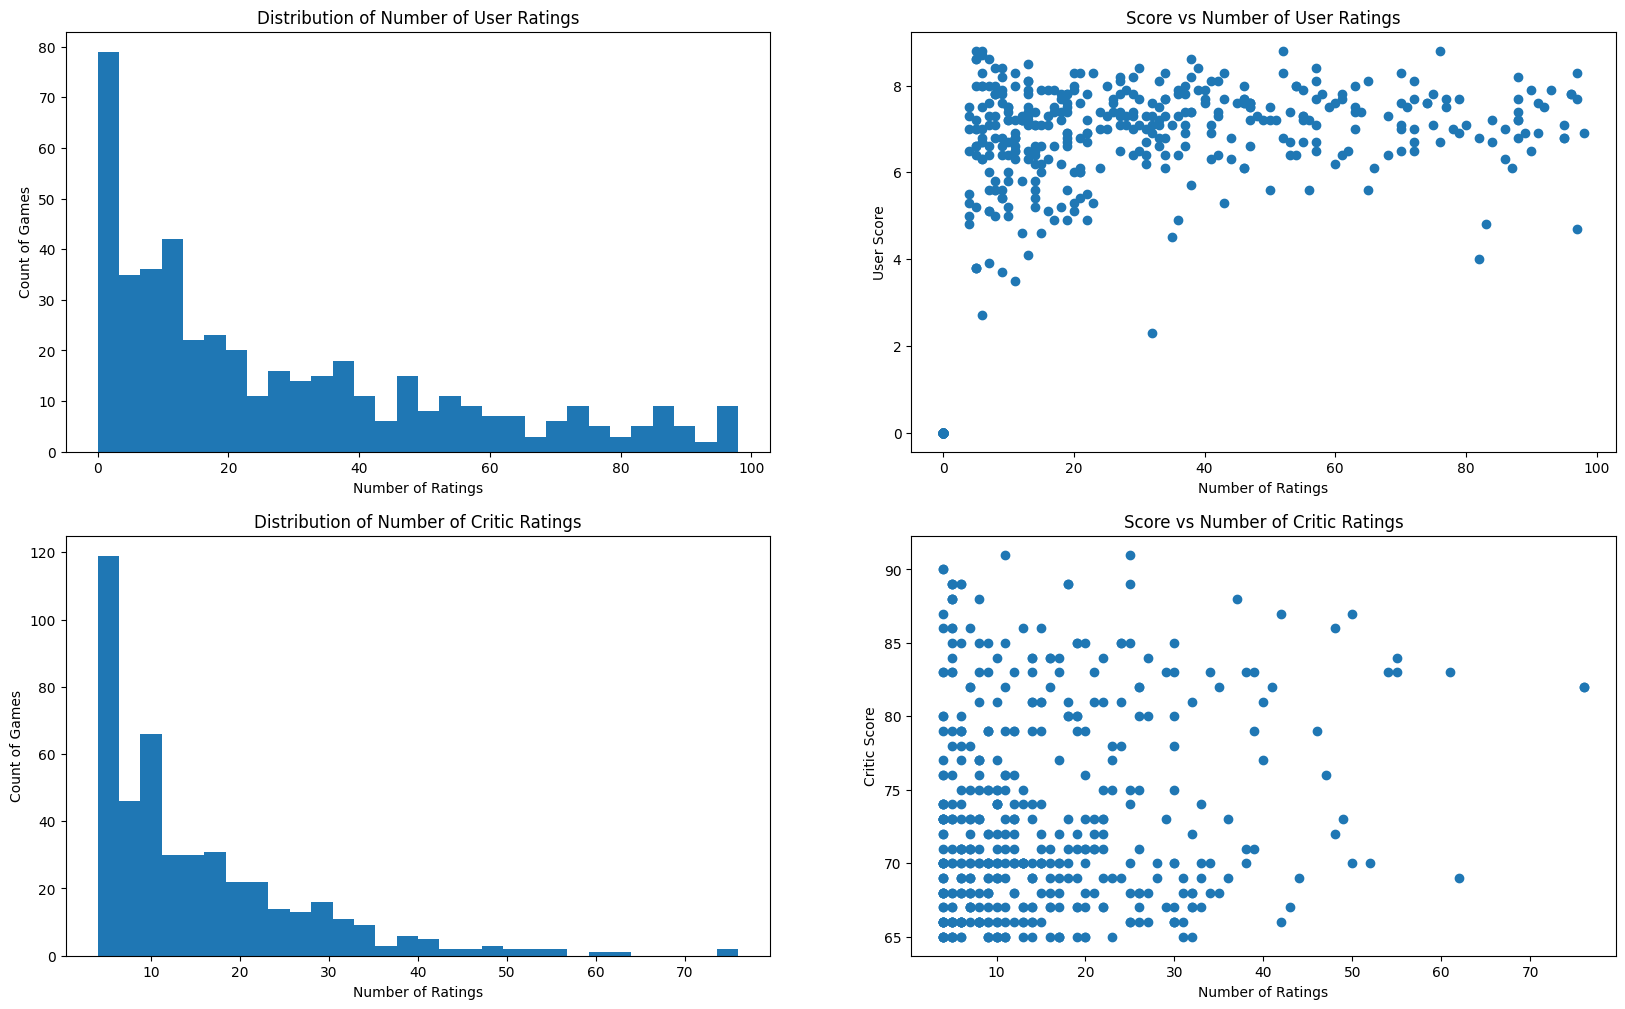

In [287]:
# EDA for game rating data
# Evalute threshold for number of user ratings required
eda = df[df.metacritic_user_rating_count < 100]
fig, axes = plt.subplots(2,2,figsize=(20, 12))
axes = axes.flatten()

# Histogram
axes[0].hist(eda['metacritic_user_rating_count'],bins=30)
axes[0].set_xlabel("Number of Ratings")
axes[0].set_ylabel("Count of Games")
axes[0].set_title("Distribution of Number of User Ratings")

# Scatter
axes[1].scatter(eda['metacritic_user_rating_count'],eda['metacritic_user_score'])
axes[1].set_xlabel("Number of Ratings")
axes[1].set_ylabel("User Score")
axes[1].set_title("Score vs Number of User Ratings")

# Histogram
axes[2].hist(eda['metacritic_rating_count'],bins=30)
axes[2].set_xlabel("Number of Ratings")
axes[2].set_ylabel("Count of Games")
axes[2].set_title("Distribution of Number of Critic Ratings")

# Scatter
axes[3].scatter(eda['metacritic_rating_count'],eda['metacritic_score'])
axes[3].set_xlabel("Number of Ratings")
axes[3].set_ylabel("Critic Score")
axes[3].set_title("Score vs Number of Critic Ratings")

In [288]:
# Print out summary statistics of data
round(df.describe(include='all'),1)

,game_name,highest_price,release_date,genre,publisher,platform,metacritic_score,metacritic_rating_count,metacritic_user_score,metacritic_user_rating_count,playstation_score,playstation_rating_count,row_id,release_year,publisher_cleaned,indie_publisher,AAA_publisher,publisher_size
count,3305,3305.0,3305,3305,3305,3305,827.0,827.0,828.0,828.0,3305,2430.0,3305.0,3305.0,3305,3305,3305,3305
unique,3085,NaN,NaN,280,757,15,NaN,NaN,NaN,NaN,204,NaN,NaN,NaN,740,2,2,2
top,Ratchet & Clank™,NaN,NaN,--,Sony Interactive Entertainment Europe,PS4,NaN,NaN,NaN,NaN,--,NaN,NaN,NaN,Sony,False,False,Not Large
freq,3,NaN,NaN,448,189,1611,NaN,NaN,NaN,NaN,875,NaN,NaN,NaN,208,2428,2655,1871
mean,NaN,28.8,2019-05-23 06:00:45.748865280,NaN,NaN,NaN,77.3,32.5,6.6,1042.8,NaN,7513.8,1771.3,2018.9,NaN,NaN,NaN,NaN
min,NaN,1.5,2007-03-23 00:00:00,NaN,NaN,NaN,65.0,4.0,0.0,0.0,NaN,1.0,0.0,2007.0,NaN,NaN,NaN,NaN
25%,NaN,15.0,2016-09-16 00:00:00,NaN,NaN,NaN,69.0,10.0,6.4,15.0,NaN,74.0,892.0,2016.0,NaN,NaN,NaN,NaN
50%,NaN,22.0,2020-03-13 00:00:00,NaN,NaN,NaN,76.0,23.0,7.4,71.5,NaN,522.5,1773.0,2020.0,NaN,NaN,NaN,NaN
75%,NaN,40.0,2022-10-25 00:00:00,NaN,NaN,NaN,85.0,47.5,8.1,369.2,NaN,3084.2,2656.0,2022.0,NaN,NaN,NaN,NaN
max,NaN,80.0,2025-09-12 00:00:00,NaN,NaN,NaN,98.0,145.0,9.5,165959.0,NaN,854788.0,3525.0,2025.0,NaN,NaN,NaN,NaN


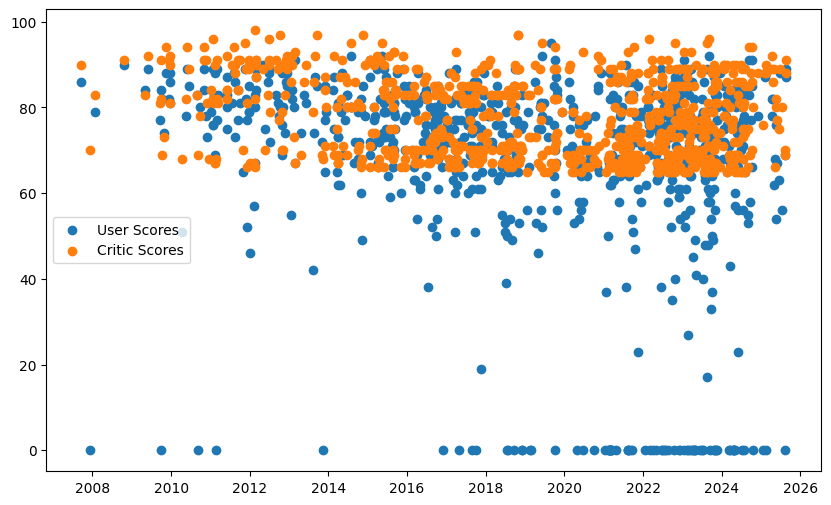

In [289]:
# See how correlated user scores are with critic scores
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df['release_date'], df.metacritic_user_score*10, label="User Scores")
ax.scatter(df['release_date'], df.metacritic_score, label="Critic Scores")
ax.legend()
plt.show()

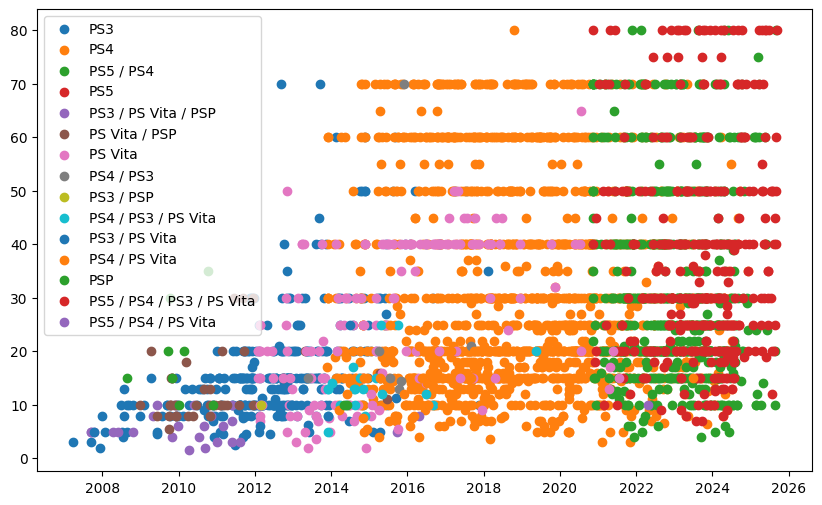

In [290]:
# Evaluate game releases by platform over time
fig, ax = plt.subplots(figsize=(10, 6))

for platform in df.platform.unique():
   df_temp = df[df.platform == platform]
   ax.scatter(df_temp['release_date'], df_temp.highest_price, label=f"{platform}")

ax.legend()
plt.show()

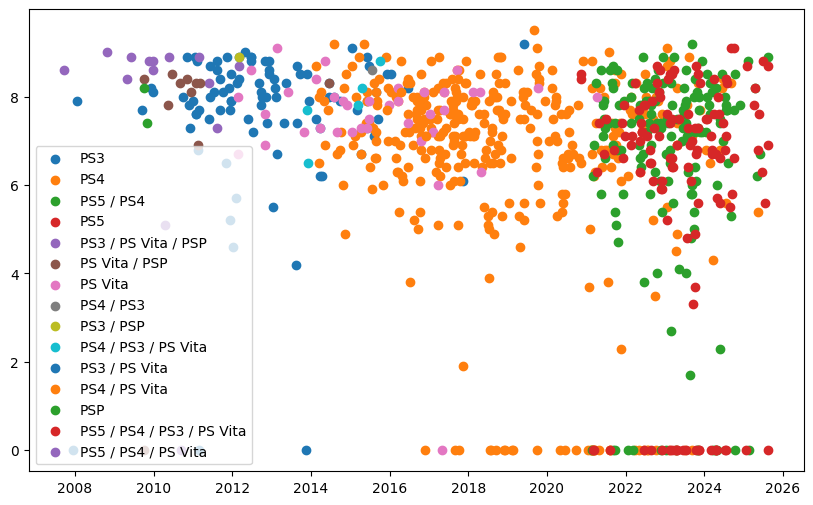

In [291]:
# Evaluate user scores by platform over time
fig, ax = plt.subplots(figsize=(10, 6))

for platform in df.platform.unique():
   df_temp = df[df.platform == platform]
   ax.scatter(df_temp['release_date'], df_temp.metacritic_user_score, label=f"{platform}")

ax.legend()
plt.show()

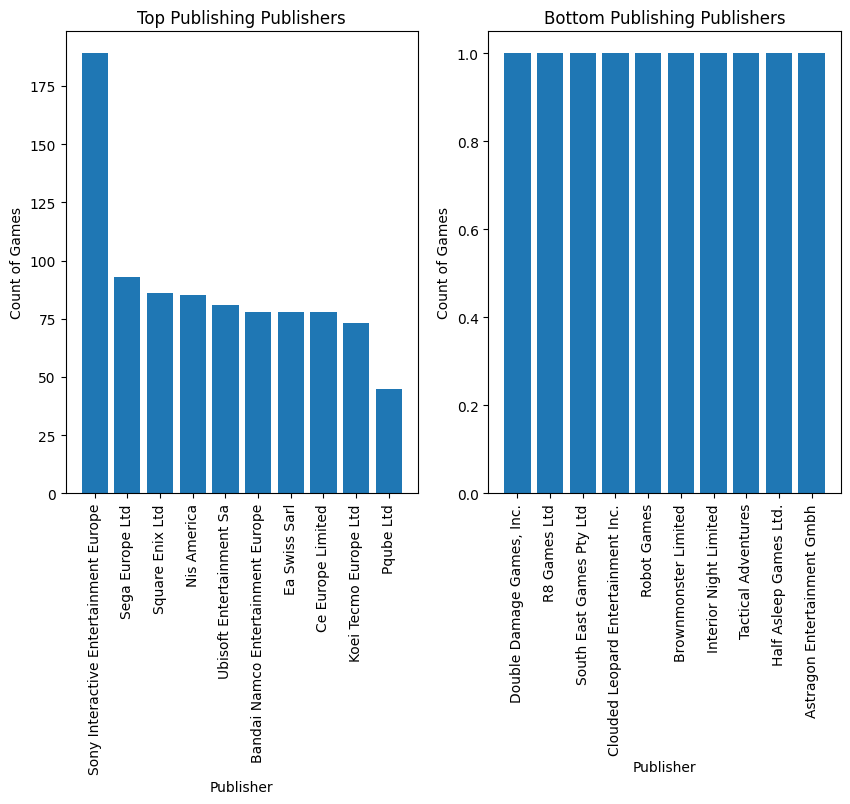

In [292]:
# Evalute top and bottom publisher counts
counts = 10
publisher_counts_top = df['publisher'].value_counts().head(counts)
publisher_counts_bottom = df['publisher'].value_counts().tail(counts)
fig, axes = plt.subplots(1,2,figsize=(10, 6))

# Largest
axes[0].bar(publisher_counts_top.index, publisher_counts_top.values)
axes[0].set_xlabel("Publisher")
axes[0].set_ylabel("Count of Games")
axes[0].set_title("Top Publishing Publishers")
axes[0].tick_params(axis='x', rotation=90)

# Smallest
axes[1].bar(publisher_counts_bottom.index, publisher_counts_bottom.values)
axes[1].set_xlabel("Publisher")
axes[1].set_ylabel("Count of Games")
axes[1].set_title("Bottom Publishing Publishers")
axes[1].tick_params(axis='x', rotation=90)

In [293]:
# Slim down dataset to only features of interest
data = df[['release_year','highest_price','genre','row_id'
           ,'publisher_size','platform','indie_publisher','AAA_publisher']]

# Some games are classified as belonging to multiple genres. Break out into categorical values
genres = ['Action', 'Shooter', 'Adventure', 'Puzzle', 'Horror', 
          'Strategy'
         ,"Role playing games","Other","Arcade"
        'Music/rhythm',"Educational", "Party",
                "Casual","--","Quiz","Brain training","Fitness",
                "Adult","Family","Unique" ,"Simulation",
                "Simulator","Racing", "Sports", "Fighting"]

other_genres = []

for g in genres:
    data[g] = False

for idx, row in data.iterrows():
    genre = row['genre']
    
    # Check if platform contains ' / '
    if '/' in genre:
        
        # Split the platform by ' / '
        game_genres = [g.strip() for g in genre.split(' / ')]
        
        # Mark individual categorical values accordingly
        for g in game_genres:
            if g in other_genres:
                data.at[idx, "Other"] = True
            else:
                data.at[idx, g] = True
            row['genre'] = row['genre'].replace(g, '')

    else:
        if genre in other_genres:
            data.at[idx, "Other"] = True
        else:
            data.at[idx, genre] = True
        row['genre'] = row['genre'].replace(genre, '')
    
    # Clean up any leftover slashes or extra spaces
    row['genre'] = row['genre'].replace('/', '').strip()
    
    # Write cleaned value back to DataFrame
    data.at[idx, 'genre'] = row['genre']


/var/folders/zl/g9l_ggdj3fv1ssvwcz55khgm0000gn/T/ipykernel_77151/1685130977.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[g] = False
/var/folders/zl/g9l_ggdj3fv1ssvwcz55khgm0000gn/T/ipykernel_77151/1685130977.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[g] = False
/var/folders/zl/g9l_ggdj3fv1ssvwcz55khgm0000gn/T/ipykernel_77151/1685130977.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [294]:
platforms = ['PS4','PS5','PS3','PSP','PS Vita']

# Also fix platforms
for p in platforms:
    data[p] = False

for idx, row in data.iterrows():
    platform = row['platform']
    
    # Check if platform contains ' / '
    if '/' in platform:
        # Split the platform by ' / '
        platform_list = [p.strip() for p in platform.split(' / ')]
        
        # Mark individual categorical values accordingly
        for p in platform_list:
            data.at[idx, p] = True
            row['platform'] = row['platform'].replace(p, '')

    else:
        data.at[idx, platform] = True
        row['platform'] = row['platform'].replace(platform, '')
    
    # Clean up any leftover slashes or extra spaces
    row['platform'] = row['platform'].replace('/', '').strip()
    
    # Write cleaned value back to DataFrame
    data.at[idx, 'platform'] = row['platform']

In [295]:
# Check to see all genres and platforms were reclassified
print("Unique genres: ",data['genre'].unique())
print("Total genre counts: ",data[genres].sum())
print('\n')
print("Unique platforms: ",data['platform'].unique())
print("Total platform counts: ",data[platforms].sum())

Unique genres:  ['']
Total genre counts:  Action                1308
Shooter                326
Adventure             1012
Puzzle                 250
Horror                 152
Strategy               203
Role playing games     486
Other                    0
ArcadeMusic/rhythm       0
Educational              3
Party                   48
Casual                  96
--                     448
Quiz                     1
Brain training           3
Fitness                  1
Adult                    3
Family                  85
Unique                 174
Simulation             132
Simulator               12
Racing                 131
Sports                  81
Fighting               117
dtype: int64


Unique platforms:  ['']
Total platform counts:  PS4        2332
PS5        1043
PS3         400
PSP          79
PS Vita     299
dtype: int64


# Splitting data into testing and training

In [ ]:
# Encode remaining categorical values
encoded_data = pd.get_dummies(data, columns=['publisher_size'])

# # Drop genre and platform now that it is no longer used
encoded_data.drop(['genre','platform'], axis=1, inplace=True)

# Split out highest price from x_cols
x_cols = encoded_data.loc[:, encoded_data.columns != 'highest_price']
y_cols = encoded_data['highest_price']

# Split data into test-train split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y_cols, test_size=0.2)

# Drop row id so it isn't included in models
X_train_features = X_train.drop(columns=['row_id'])
X_test_features = X_test.drop(columns=['row_id'])

X_train_features.head()

,release_year,indie_publisher,AAA_publisher,Action,Shooter,Adventure,Puzzle,Horror,Strategy,Role playing games,...,Fighting,Arcade,Music/rhythm,PS4,PS5,PS3,PSP,PS Vita,publisher_size_Large,publisher_size_Not Large
998,2023,True,False,True,False,True,True,False,False,False,...,False,NaN,NaN,True,True,False,False,False,True,False
629,2019,False,False,True,False,False,False,False,False,False,...,False,NaN,NaN,True,False,False,False,False,False,True
2946,2021,False,False,False,True,False,False,False,False,False,...,False,NaN,NaN,True,False,False,False,False,True,False
113,2017,False,False,True,False,True,False,False,False,False,...,False,NaN,NaN,True,False,False,False,False,True,False
165,2011,False,True,True,False,True,False,False,False,False,...,False,NaN,NaN,False,False,True,False,False,True,False


# Analysis using baseline model
For this project, I used a Random Forest Regressor as that handles both categorical and numerical features effectively, which having generally strong and interpretable performance.

In [241]:
# Try out random forest classifier
rf = RandomForestRegressor()
rf.fit(X_train_features, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


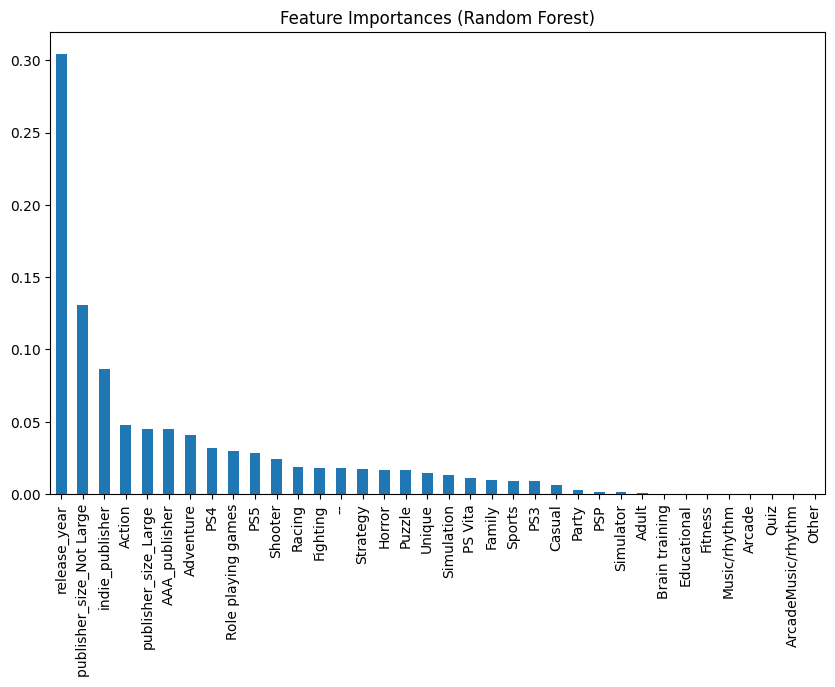

In [296]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X_train_features.columns)
feat_importance = feat_importance.sort_values(ascending=False)

# Quick bar plot
plt.figure(figsize=(10,6))
feat_importance.plot(kind='bar')
plt.title("Feature Importances (Random Forest)")
plt.show()


In [297]:
y_pred = rf.predict(X_test_features)
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", round(mae,2))

r2 = r2_score(y_test, y_pred)
print("R²:", round(r2,2))

MAE: 10.38
R²: 0.31


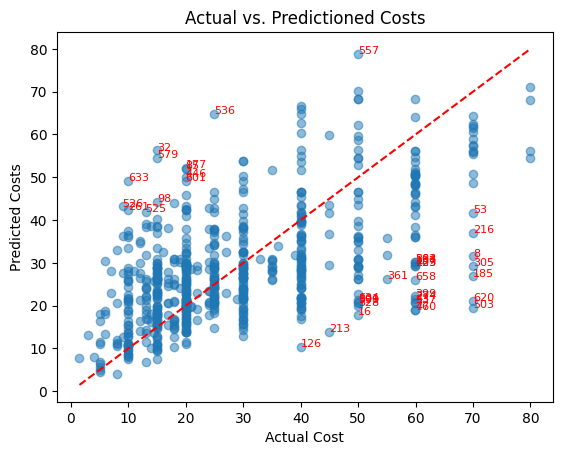

In [ ]:
import matplotlib.pyplot as plt

# Compute residuals
residuals = y_test - y_pred

# Classify anything outside of 2x standard dev as an outlier
threshold = 2 * np.std(residuals)

# Find outlier indices
outliers = np.where(np.abs(residuals) > threshold)[0]

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Costs")
plt.title("Actual vs. Predictioned Costs")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45 degree line

# Mark outliers in red
for i in outliers:
    plt.annotate(i, (y_test.iloc[i], y_pred[i]), color='red', fontsize=8)

plt.show()


In [ ]:
# Explore outliers
misclassified = X_test.iloc[[53]]

# Merge back with original df to see full info
full_misclassified = misclassified.merge(df, on='row_id', suffixes=('_split','_original'))

full_misclassified[['game_name','highest_price','release_year_split'
                    ,'publisher_cleaned','platform','publisher_size'
                    ]]



,game_name,highest_price,release_year_split,publisher_cleaned,platform,publisher_size
0,DEAD OR ALIVE 6,69.99,2019,Koei Tecmo Games,PS4,Large


In [ ]:
# Start to tune hyperparameters
param_grid = {
    'n_estimators': [10,50,100,250,500],
    'min_samples_split': [2,5,10,20,50],
    'max_depth': [None,1,5,10,20],
    'max_features': ["sqrt","log2",None],
    'min_samples_leaf': [1,5,10,20]
}

pretuned_rf = RandomForestRegressor()

grid = GridSearchCV(pretuned_rf, param_grid, cv=3, scoring='r2')
grid.fit(X_train, y_train)

print("Best params: ",grid.best_params_)
print("Best accuracy: ",grid.best_score_)


Best params:  {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250}
Best accuracy:  0.4398303258502374


# Analysis of tuned model + Result
This model's best performance yielded a MAE of 9.91 and an R-Squared of 0.401

In [270]:
tuned_rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=20,
    min_samples_split=5,
    max_features='log2',
    min_samples_leaf=1
)
tuned_rf.fit(X_train_features, y_train)

y_pred = tuned_rf.predict(X_test_features)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", round(mae,2))

r2 = r2_score(y_test, y_pred)
print("R²:", round(r2,3))

MAE: 9.91
R²: 0.401


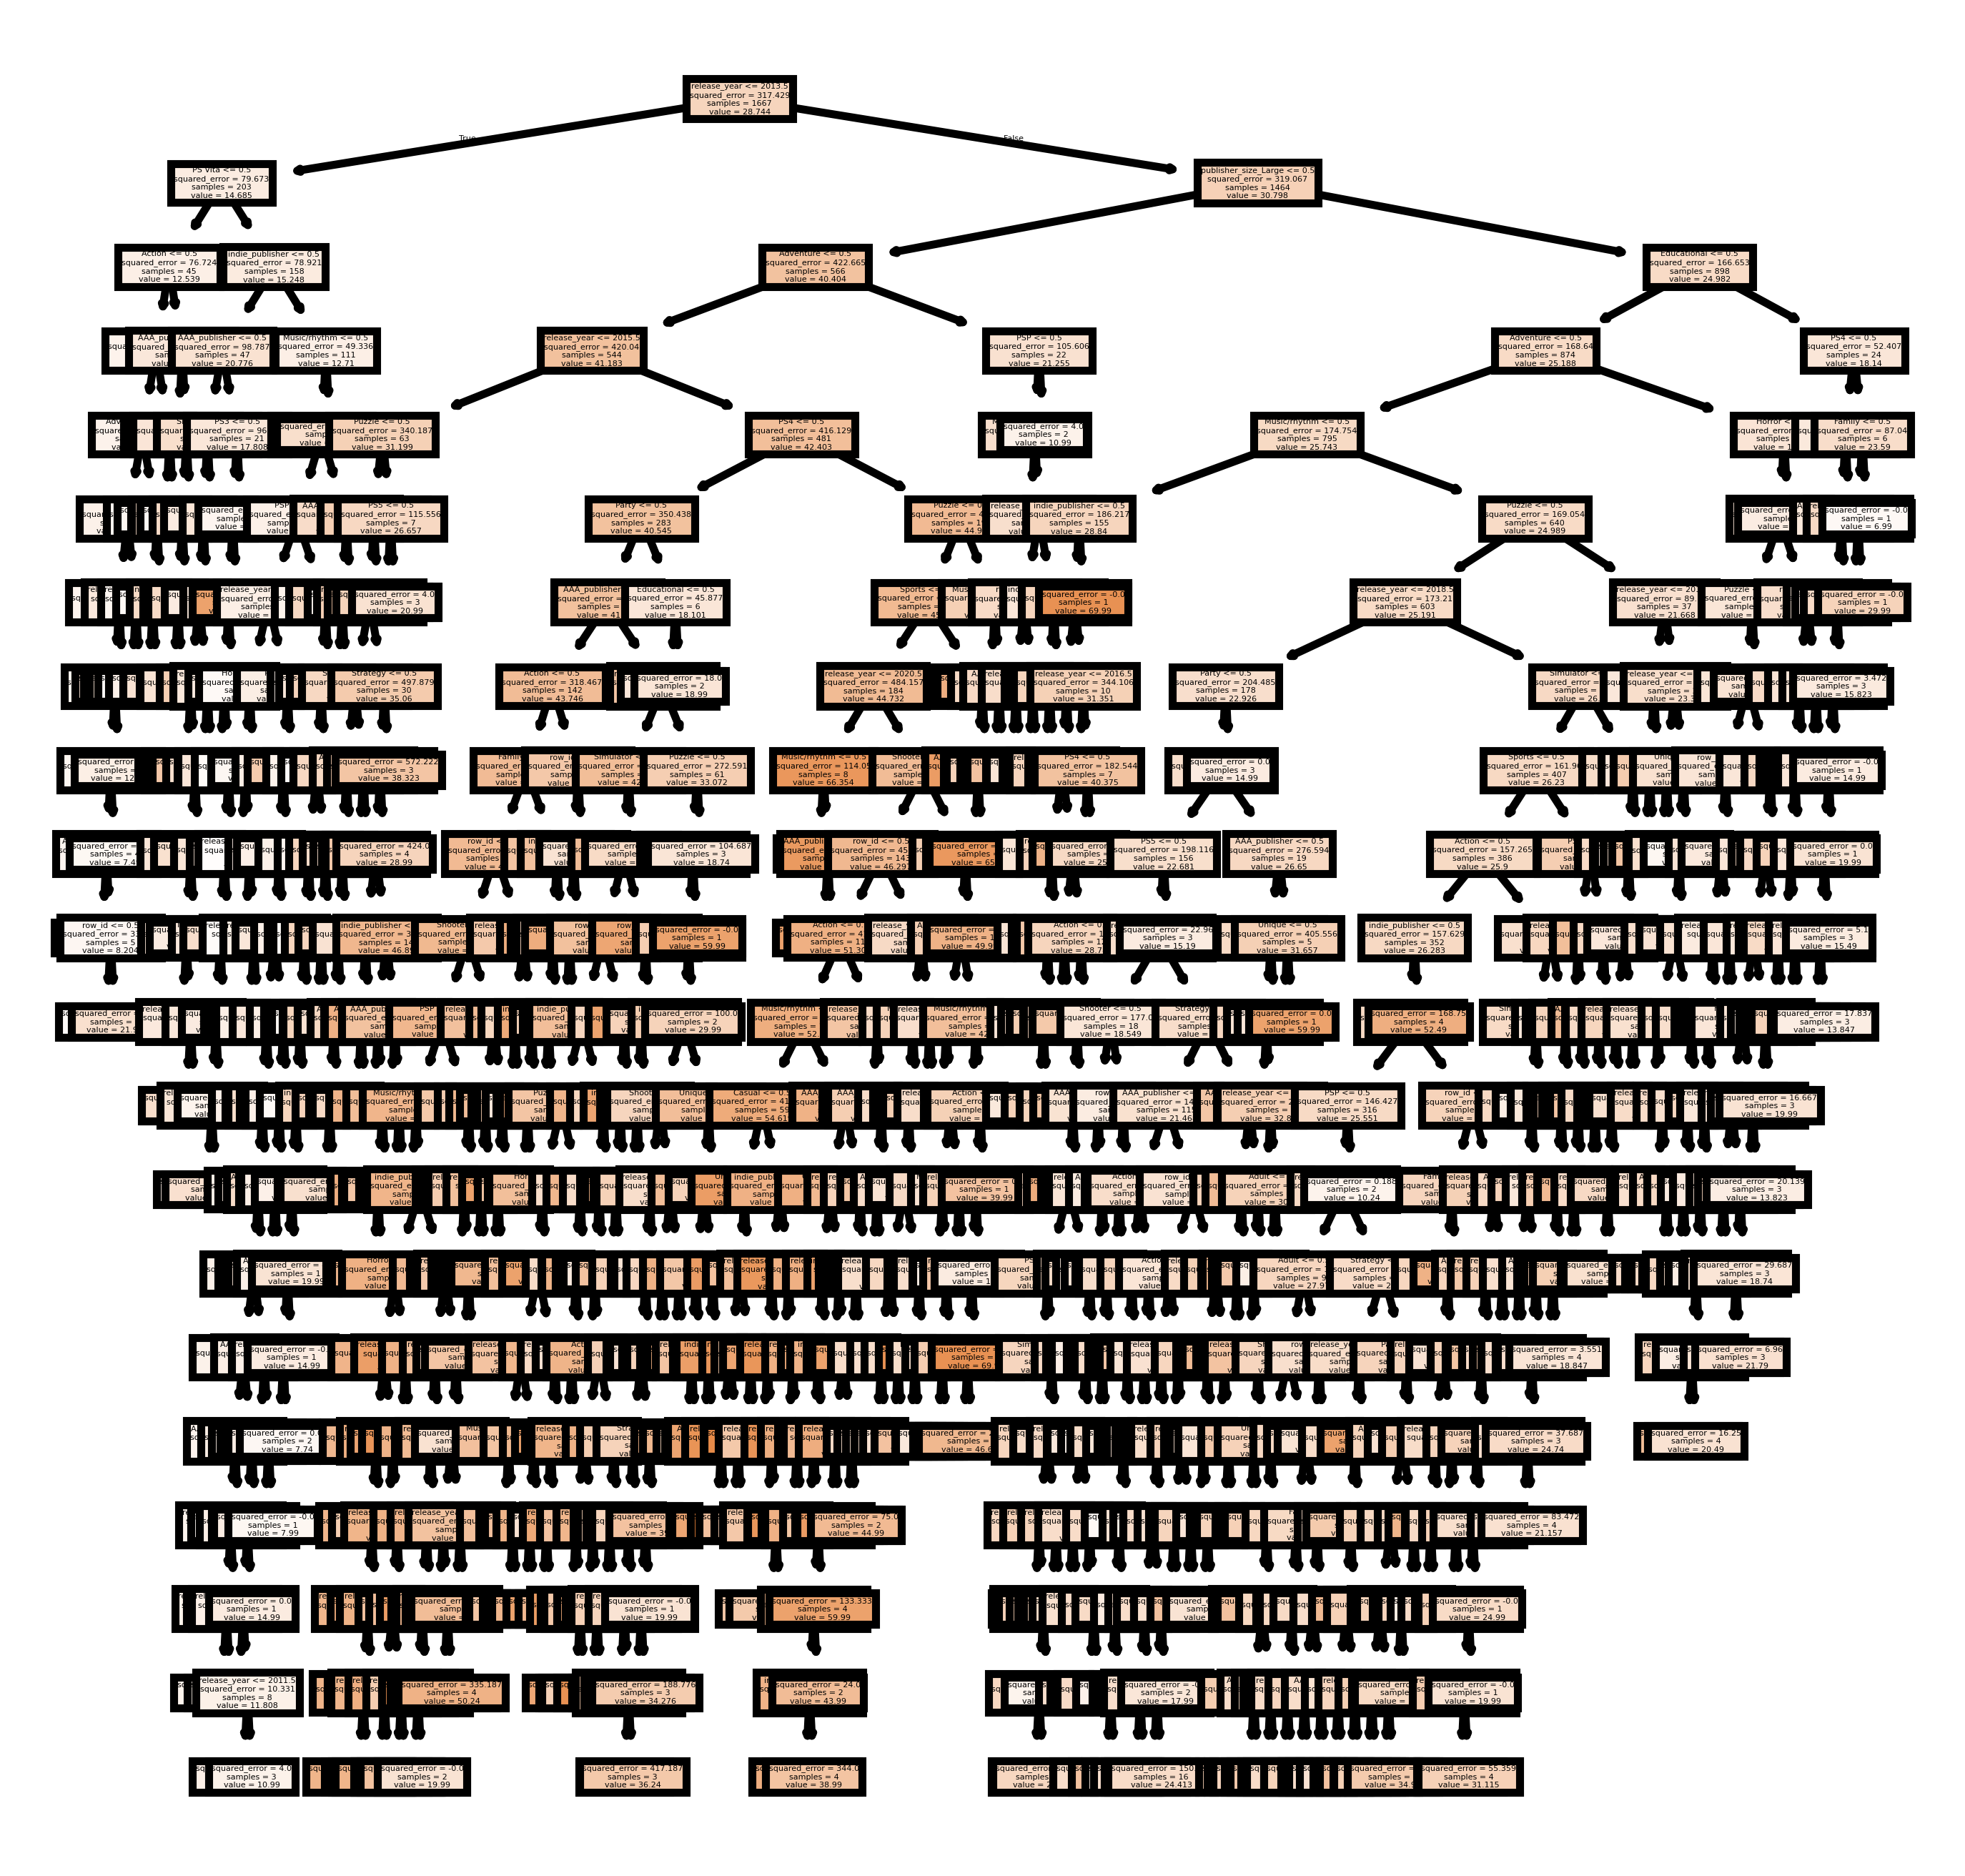

In [271]:
from sklearn import tree
fn=X_test.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(tuned_rf.estimators_[0],
               feature_names = fn, 
               filled = True)
fig.savefig('rf_individualtree.png')

# Discussion / Conclusion
Overall this model shows limited predictive power in predicting the price of Playstation games, but it does show promise that it could eventually be an effective model. This is evident as predictive power increased through feature engineering and hyperparameter tuning. 

I believe this model could be further improved through the following:
* Adjust prices for inflation: This may decrease dependence on release_year and would allow for other features potentially to show more predictive power
* Feature engineer genre: Certain genres were found to have predictive power while others did not. Doing additional feature engineering might help to elevate differences in cost by genre.
* Capturing game re-releases: As discussed, games can be re-released on new platforms. This creates inflated costs on historical games. Finding a way to capture games that have been re-released would control for some of that unexplained variability.
* Including game developer feature: The dataset used for this project included the publisher of a game, but it did not include the company that developed said game. Including this element could help to further parse out differences in costs that may be driven by a particular game development studio.
